@author: Pavlo Mospan

In [1]:
!pip install keras-tuner
!pip install yfinance

import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout, Activation
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import load_model
import yfinance as yf
from datetime import datetime, date, timedelta
import pandas as pd
from numpy import concatenate

     |████████████████████████████████| 71kB 8.2MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=4caa16cdcc585c46e07920d32e04b5cbcccc030db58a65d71c09edd4daea2bb8
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=99732880c9a6eedd301f2f1f5b6565e8ae0574768fd712cd0381bf56a51455c9
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables
     |████████████████████████████████| 5.5MB 15.6MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=00f369c6062a2361ca2326907bf010cc15a10919a062ffcaff9b6ac66f255e72
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Data


In [3]:
today = datetime.today().strftime('%Y-%m-%d')
start_date = '2015-08-07'
idx = pd.date_range(start_date, today)

df_A = yf.download("BTC-USD", start=start_date, end=today)
df_A = df_A["Close"]
df_A = df_A.reindex(idx, fill_value=0, method="nearest")

# The S&P 500 - stock market index that measures the stock performance of 500 large companies listed on stock exchanges in the US. 
df_B = yf.download("%5EGSPC", start=start_date, end=today)
df_B = df_B["Close"]
df_B = df_B.reindex(idx, fill_value=0, method="nearest")

# US Dollar/USDX - Index - Cash
df_C = yf.download("DX-Y.NYB", start=start_date, end=today)
df_C = df_C["Close"]
df_C = df_C.reindex(idx, fill_value=0, method="nearest")

# Gold
df_D = yf.download("GC=F", start=start_date, end=today)
df_D = df_D["Close"]
df_D = df_D.reindex(idx, fill_value=0, method="nearest")

timeseries=  pd.concat([df_A, df_B, df_C, df_D], axis=1)

timeseries.columns=(["Close-btc", "Close-sp500", "Close-dxy", "Close-gold"])
timeseries

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Close-btc,Close-sp500,Close-dxy,Close-gold
2015-08-07,279.584991,2077.570068,97.559998,1094.099976
2015-08-08,260.997009,2077.570068,97.559998,1094.099976
2015-08-09,265.083008,2104.179932,97.160004,1104.199951
2015-08-10,264.470001,2104.179932,97.160004,1104.199951
2015-08-11,270.385986,2084.070068,97.290001,1107.599976
...,...,...,...,...
2021-01-19,36069.804688,3798.909912,90.500000,1839.500000
2021-01-20,36069.804688,3851.850098,90.470001,1865.900024
2021-01-21,31898.572266,3853.070068,90.129997,1865.300049
2021-01-22,31898.572266,3841.469971,90.239998,1855.699951


In [4]:
scl = MinMaxScaler()

timeseries[["Close-btc", "Close-sp500", "Close-dxy", "Close-gold"]] = scl.fit_transform(timeseries[["Close-btc", "Close-sp500", "Close-dxy", "Close-gold"]])

timeseries["Close-btc-output"] = timeseries["Close-btc"]
timeseries["Close-btc-output"] = timeseries["Close-btc-output"].shift(-1)
#timeseries.drop(timeseries.tail(1).index, inplace=True)
timeseries.loc[today, 'Close-btc-output']
timeseries

,Close-btc,Close-sp500,Close-dxy,Close-gold,Close-btc-output
2015-08-07,0.001702,0.122772,0.610204,0.043270,0.001244
2015-08-08,0.001244,0.122772,0.610204,0.043270,0.001345
2015-08-09,0.001345,0.135920,0.582994,0.053363,0.001330
2015-08-10,0.001330,0.135920,0.582994,0.053363,0.001476
2015-08-11,0.001476,0.125984,0.591837,0.056760,0.001377
...,...,...,...,...,...
2021-01-19,0.883515,0.973241,0.129932,0.788148,0.883515
2021-01-20,0.883515,0.999397,0.127891,0.814530,0.780742
2021-01-21,0.780742,1.000000,0.104762,0.813930,0.780742
2021-01-22,0.780742,0.994269,0.112245,0.804337,0.780742


#### Filling today's **Close-btc-output** value with yesterday value. This is needed for later proper prediction

In [5]:
yesterday = date.today() - timedelta(days=1)
yesterday = yesterday.strftime('%Y-%m-%d')

timeseries.loc[today, 'Close-btc-output'] = timeseries.loc[yesterday, 'Close-btc-output']
timeseries
print(timeseries)
array = timeseries.values
print(array)

            Close-btc  Close-sp500  Close-dxy  Close-gold  Close-btc-output
2015-08-07   0.001702     0.122772   0.610204    0.043270          0.001244
2015-08-08   0.001244     0.122772   0.610204    0.043270          0.001345
2015-08-09   0.001345     0.135920   0.582994    0.053363          0.001330
2015-08-10   0.001330     0.135920   0.582994    0.053363          0.001476
2015-08-11   0.001476     0.125984   0.591837    0.056760          0.001377
...               ...          ...        ...         ...               ...
2021-01-19   0.883515     0.973241   0.129932    0.788148          0.883515
2021-01-20   0.883515     0.999397   0.127891    0.814530          0.780742
2021-01-21   0.780742     1.000000   0.104762    0.813930          0.780742
2021-01-22   0.780742     0.994269   0.112245    0.804337          0.780742
2021-01-23   0.780742     0.994269   0.112245    0.804337          0.780742

[1997 rows x 5 columns]
[[0.00170226 0.12277239 0.61020397 0.04326964 0.00124429]
 [0.0

In [6]:
#number of days to take in a row before Y
X_quantity = 7  
mod = len(array) % X_quantity

# how many predictions to make
times = 3

# deleting first-mod values to have /mod-zero array
for i_ in range(mod):
  array = np.delete(array, 0, 0)

# for splitting into train/test
division = X_quantity * 3
split = len(array) - division
print('Division: ', division, 'Split is on: ', split)

predict = array[split:]
train = array[:split]

Division:  21 Split is on:  1974


In [7]:
def get_X_values(values):
  x = []
  ready_X = []
  COUNT = 1
  for i_ in values:
    x.extend(i_)
    if COUNT % X_quantity == 0:
      ready_X.append(x)
      x = []

    COUNT += 1

  ready_X = np.array(ready_X)
  return ready_X

def get_Y_targets(targets):
  ready_Y = []
  for i_ in range(int(len(targets) / X_quantity)):
    i_ += 1
    ready_Y.append(targets[i_ * X_quantity -1])

  ready_Y = np.array(ready_Y)
  return ready_Y

In [8]:
predict_values = predict[:, :-1]
predict_target = predict[:, -1]

print('predict_values.shape: {} | predict_target.shape: {}'.format(predict_values.shape, predict_target.shape))

predict_X = get_X_values(predict_values)
print('\n predict_X type: {} \n predict_X.shape: {} \n predict_X: \n{}'.format(type(predict_X), predict_X.shape, predict_X))

predict_Y = get_Y_targets(predict_target)
print('\nPred Y: {}'.format(predict_Y))

predict_values.shape: (21, 4) | predict_target.shape: (21,)

 predict_X type: <class 'numpy.ndarray'> 
 predict_X.shape: (3, 28) 
 predict_X: 
[[0.8025091  0.92469323 0.08775514 0.89327465 0.78254933 0.92469323
  0.08775514 0.89327465 0.83233152 0.937643   0.05782353 0.90126906
  0.90210573 0.94815677 0.06394572 0.85550117 0.96485174 0.97565204
  0.08435409 0.86089741 1.         0.98597318 0.10068047 0.78275204
  0.98661983 0.98597318 0.10068047 0.78275204]
 [0.93985362 0.97358685 0.13265333 0.7982412  0.87111789 0.97358685
  0.13265333 0.7982412  0.83061993 0.9743674  0.09932015 0.79154593
  0.9142277  0.97864121 0.11768727 0.8022384  0.96032531 0.97157593
  0.11224497 0.79894078 0.90213046 0.95809265 0.14897971 0.77795547
  0.88618386 0.95809265 0.14897971 0.77795547]
 [0.87665218 0.9732409  0.12993218 0.78814829 0.89731876 0.9732409
  0.12993218 0.78814829 0.88351464 0.9732409  0.12993218 0.78814829
  0.88351464 0.99939724 0.12789145 0.81452984 0.78074231 1.
  0.10476193 0.81393029 

In [9]:
train_values = train[:, :-1]
train_target = train[:, -1]

print('train_values.shape: {} | train_target.shape : {}'.format(train_values.shape, train_target.shape))

train_X = get_X_values(train_values)
print('\n type of train_X: {} \n train_X.shape: {} \n train_X: \n {}'.format(type(train_X), train_X.shape, train_X))

train_Y = get_Y_targets(train_target)
print('\n len(train_Y) : {} '.format(len(train_Y)))

train_values.shape: (1974, 4) | train_target.shape : (1974,)

 type of train_X: <class 'numpy.ndarray'> 
 train_X.shape: (282, 28) 
 train_X: 
 [[1.34495920e-03 1.35919624e-01 5.82993514e-01 ... 1.29674588e-01
  5.42857202e-01 6.20565390e-02]
 [1.18293685e-03 1.35059941e-01 5.59864000e-01 ... 7.00646005e-02
  4.24490037e-01 1.08723825e-01]
 [4.35458679e-04 3.16849398e-02 3.21088418e-01 ... 7.89480334e-02
  5.11564757e-01 8.22423611e-02]
 ...
 [4.66450698e-01 8.98428319e-01 1.44898246e-01 ... 9.29021315e-01
  9.72789020e-02 8.34315922e-01]
 [5.73255830e-01 9.21862194e-01 9.86397365e-02 ... 9.41842621e-01
  1.19047582e-01 8.25821867e-01]
 [6.42120050e-01 9.41842621e-01 1.19047582e-01 ... 9.24693226e-01
  8.77551370e-02 8.93274654e-01]]

 len(train_Y) : 282 


In [ ]:
timeseries[["Close-btc", "Close-sp500", "Close-dxy", "Close-gold"]].shape

(1997, 4)

In [10]:
#splitting into Train and Test

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
predict_X = predict_X.reshape((predict_X.shape[0], 1, predict_X.shape[1]))

X_train, X_validate, Y_train, Y_validate = train_test_split(train_X, train_Y, test_size=0.20, random_state=42)

print('X_train.shape: {} |  Y_train: {}'.format( X_train.shape, Y_train.shape))

X_train.shape: (225, 1, 28) |  Y_train: (225,)


In [12]:
forward_days=1

predict_X, predict_X.shape

(array([[[0.8025091 , 0.92469323, 0.08775514, 0.89327465, 0.78254933,
          0.92469323, 0.08775514, 0.89327465, 0.83233152, 0.937643  ,
          0.05782353, 0.90126906, 0.90210573, 0.94815677, 0.06394572,
          0.85550117, 0.96485174, 0.97565204, 0.08435409, 0.86089741,
          1.        , 0.98597318, 0.10068047, 0.78275204, 0.98661983,
          0.98597318, 0.10068047, 0.78275204]],
 
        [[0.93985362, 0.97358685, 0.13265333, 0.7982412 , 0.87111789,
          0.97358685, 0.13265333, 0.7982412 , 0.83061993, 0.9743674 ,
          0.09932015, 0.79154593, 0.9142277 , 0.97864121, 0.11768727,
          0.8022384 , 0.96032531, 0.97157593, 0.11224497, 0.79894078,
          0.90213046, 0.95809265, 0.14897971, 0.77795547, 0.88618386,
          0.95809265, 0.14897971, 0.77795547]],
 
        [[0.87665218, 0.9732409 , 0.12993218, 0.78814829, 0.89731876,
          0.9732409 , 0.12993218, 0.78814829, 0.88351464, 0.9732409 ,
          0.12993218, 0.78814829, 0.88351464, 0.99939724, 0.

#### Training The Model

In [13]:
#Training the model

class MyHyperModel(HyperModel):

    def __init__(self, num_classes):
        self.num_classes = num_classes

    def build(self, hp):
        
        # Specify model
        model = Sequential()
        NUM_NEURONS_FirstLayer = hp.Choice('NUM_NEURONS_FirstLayer',values=[80, 90, 100, 120])

        model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))

        model.add(Dropout(hp.Float('dropout_1', 0, 0.4, step=0.1, default=0)))

        
        NUM_NEURONS_SecondLayer = hp.Choice('NUM_NEURONS_SecondLayer',values=[30, 40, 50, 60, 70])
        model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))

        model.add(Dropout(hp.Float('dropout_2', 0, 0.4, step=0.1, default=0)))

        # Output layer
        model.add(Dense(forward_days, activation='linear'))

        # Compile the constructed model and return it
        model.compile(
            optimizer=Adam(
                hp.Choice('learning_rate',
                          values=[0.01, 0.001, 0.0001])),
            loss='mean_squared_error')

        return model

In [14]:
hypermodel = MyHyperModel(num_classes=1)    

# Construct the RandomSearch tuner
random_tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=100,
    executions_per_trial = 1,
    seed=10, 
    project_name='lstm-kerastuner-multi',
    directory="/content")

# Search for the best parameters of the neural network using the contructed random search tuner
random_tuner.search(X_train, Y_train,
             epochs=100,
             validation_data=(X_validate, Y_validate))

#get the best model

random_params = random_tuner.get_best_hyperparameters()[0]
best_model = random_tuner.get_best_models(1)[0]

Trial 100 Complete [00h 00m 10s]
val_loss: 0.00011223337787669152

Best val_loss So Far: 7.249882037285715e-05
Total elapsed time: 00h 19m 21s
INFO:tensorflow:Oracle triggered exit


In [15]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 100)            51600     
_________________________________________________________________
dropout (Dropout)            (None, 1, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                15720     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 67,351
Trainable params: 67,351
Non-trainable params: 0
_________________________________________________________________


#### Saving the model

In [16]:
#Saving the model

file_name = 'LSTM_MULTI-7.h5'
best_model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `LSTM_MULTI-7.h5` to disk


#### Predicting on best_model recently train 
# NEEDS RECODING - USE CODE BELOW THESE CELLS

In [17]:
yhat = best_model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

inv_yhat = concatenate((yhat, X_test[:,1:]), axis=1)
inv_yhat = scl.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

NameError: ignored

In [ ]:
Y_test = Y_test.reshape((len(Y_test)), 1)
inv_y = concatenate((Y_test, X_test[:, 1:]), axis=1)
inv_y = scl.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [ ]:
print('PRED: \n', inv_yhat, ' \nREAL: \n', inv_y)

PRED: 
 [31807.49179664 32415.1705936  31662.89979524 33552.0475518
 36119.86253894 38391.77545894 39619.23621309 39148.23627799
 37465.30672779 34965.94729224 33479.00765308 36550.42587139
 38204.47766355 36080.04524652 35498.06298519 35168.22949186
 35924.42903942 35419.90893883 31643.01171206 31643.01171206]  
REAL: 
 [32782.0234375  31971.9140625  33992.4296875  36824.36328125
 39371.04296875 40797.609375   40254.546875   38356.44140625
 35566.65625    33922.9609375  37316.359375   39187.328125
 36825.3671875  36178.140625   35791.27734375 36630.07421875
 36069.8046875  31928.91601562 31928.91601562 31928.91601562]


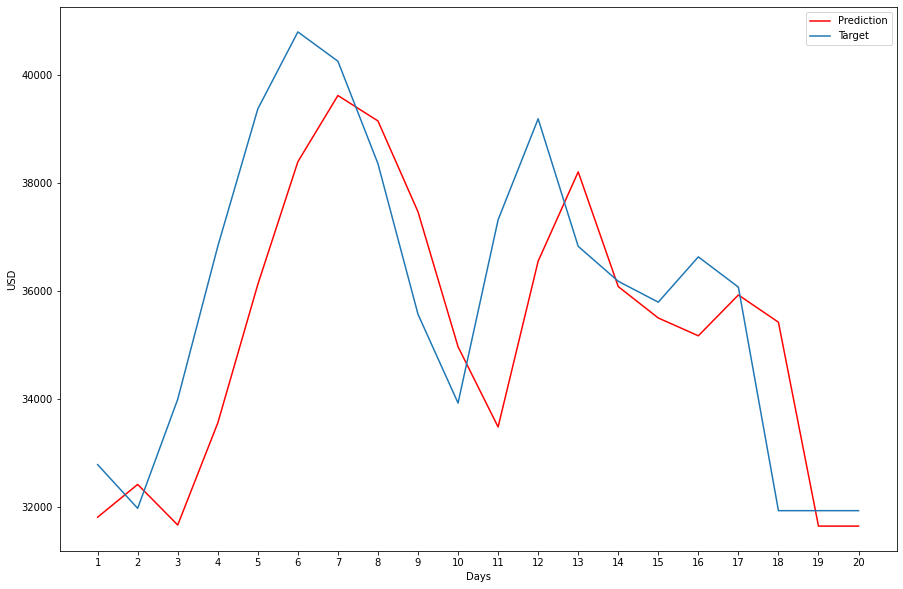

In [ ]:
plt.figure(figsize = (15,10))
plt.plot(inv_yhat, color='r', label='Prediction') 
plt.plot(inv_y, label='Target')
plt.xticks(np.arange(0, 20, 1), np.arange(1, 21, 1))
plt.xlabel('Days')
plt.ylabel('USD')
plt.legend(loc='best')
plt.show()

-------

#### Loading model fron **/content** or **gdrive** and predicting

In [ ]:
# Loading Model

file_name = '/content/gdrive/MyDrive/ColabData/LSTM_MULTI-7.h5'
#file_name = '/content/LSTM_MULTI.h5'
model = tf.keras.models.load_model(file_name)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 100)            51600     
_________________________________________________________________
dropout (Dropout)            (None, 1, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 70)                47880     
_________________________________________________________________
dropout_1 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 71        
Total params: 99,551
Trainable params: 99,551
Non-trainable params: 0
_________________________________________________________________


In [18]:
#yhat = model.predict(predict_X)
yhat = best_model.predict(predict_X)
yhat, yhat.shape

(array([[1.0178818 ],
        [1.0010853 ],
        [0.90966254]], dtype=float32), (3, 1))

In [20]:
g = yhat

g = np.insert(g, [1], .4, axis = 1)
g = np.insert(g, [2], .4, axis = 1)
g = np.insert(g, [3], .4, axis = 1)
g, g.shape

(array([[1.0178818 , 0.4       , 0.4       , 0.4       ],
        [1.0010853 , 0.4       , 0.4       , 0.4       ],
        [0.90966254, 0.4       , 0.4       , 0.4       ]], dtype=float32),
 (3, 4))

In [21]:
h = scl.inverse_transform(g)

h[:, :1]

array([[41523.375],
       [40841.656],
       [37131.074]], dtype=float32)

In [24]:
predict_Y # real values

array([0.93985362, 0.87665218, 0.78074231])

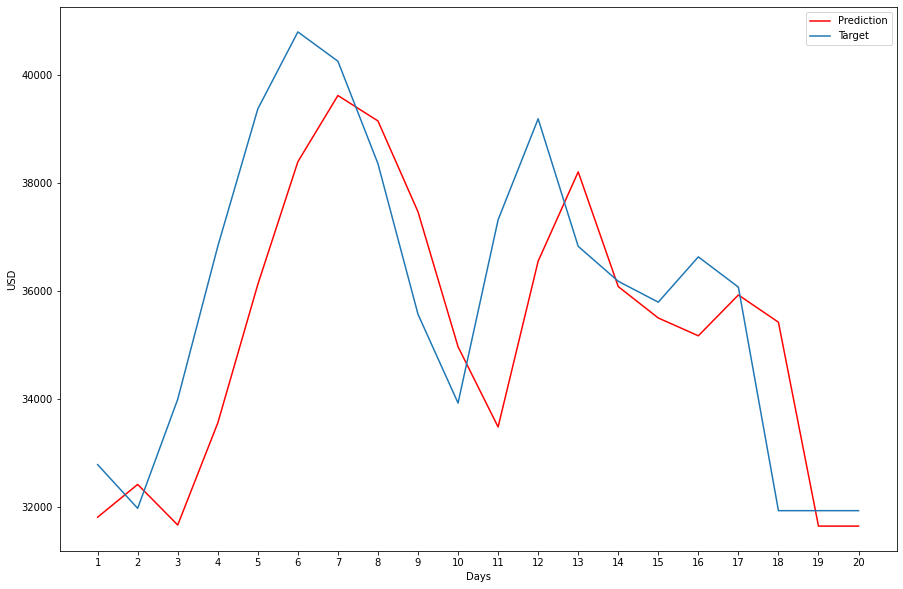

In [ ]:
plt.figure(figsize = (15,10))
plt.plot(inv_yhat, color='r', label='Prediction') 
plt.plot(inv_y, label='Target')
plt.xticks(np.arange(0, 20, 1), np.arange(1, 21, 1))
plt.xlabel('Days')
plt.ylabel('USD')
plt.legend(loc='best')
plt.show()

#DELETE LAST REAL VALUE - 

In [ ]:
print('PRED: \n', inv_yhat, ' \nREAL: \n', inv_y) 


PRED: 
 [0.72545075 0.79005134 0.80548388 0.78637981 0.83389902 0.89982134
 0.9578917  0.99042833 0.97844297 0.93589759 0.87229002 0.8340897
 0.91234237 0.95437187 0.90111589 0.88629836 0.87752491 0.89676785
 0.88392913 0.86212522]  
REAL: 
 [0.78637698 0.8025091  0.78254933 0.83233152 0.90210573 0.96485174
 1.         0.98661983 0.93985362 0.87111789 0.83061993 0.9142277
 0.96032531 0.90213046 0.88618386 0.87665218 0.89731876 0.88351464
 0.86021214 0.86021214]
